In [1]:
from math import sqrt

import pandas as pd
import sqlite3

import seaborn as sns
sns.set(style="white", color_codes=True)
sns.set_context('notebook', font_scale=1.5, rc={'line.linewidth': 2.5, "figure.figsize" : (8, 4)})

import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display

%matplotlib inline

In [2]:
con = sqlite3.connect("nlsy79.sqlite")

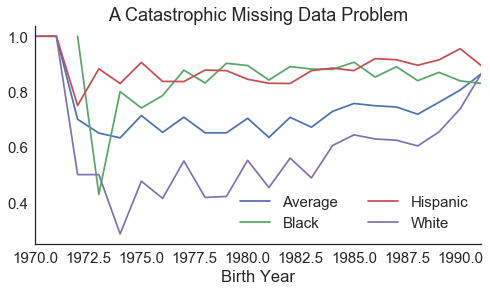

In [3]:
df = pd.read_sql(con = con, 
                 sql = """select
                            cyrb, crace,
                            hstdegree_dli >= 0 'Valid Data'
                          from cya_static 
                          where cyrb > 0 and cyrb < 1992;""")

df["crace"] = df["crace"].map({1 : "Black", 2 : "Hispanic", 3 : "White"})
ax = df.groupby("cyrb").mean().plot(y = "Valid Data", label = "Average", figsize = (8, 4), 
                                    title = "A Catastrophic Missing Data Problem")

for l in ["Black", "Hispanic", "White"]:
    df[df['crace'] == l].groupby("cyrb").mean().plot(y = "Valid Data", label = l, ax = ax)

ax.set(xlabel = "Birth Year")
plt.legend(ncol = 2, loc = "lower right")
sns.despine()

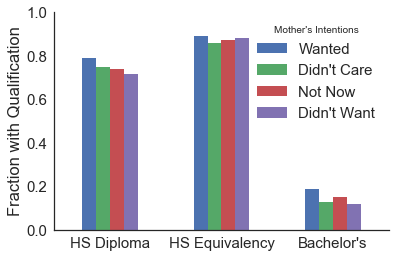

In [4]:
df = pd.read_sql(con = con, index_col = "mwanted",
                 sql = """select 
                            mwanted,
                            1.*sum(hstdegree_dli > 1  AND 2012 - cyrb >= 20)/sum(2012 - cyrb >= 20) HS_avg,
                            sum(2012 - cyrb >= 20) HS_N, 
                            1.*sum(hstdegree_dli >= 1 AND 2012 - cyrb >= 22)/sum(2012 - cyrb >= 22) HS_eq_avg,
                            sum(2012 - cyrb >= 22) HS_eq_N, 
                            1.*sum(hstdegree_dli > 3  AND 2012 - cyrb >= 24)/sum(2012 - cyrb >= 24) BA_avg,
                            sum(2012 - cyrb >= 24) BA_N
                          from cya_static
                          join fer on 
                            cya_static.r = fer.r and
                            cya_static.c = fer.p
                          where 
                            mwanted > 0 and
                            hstdegree_dli >= 0
                          group by mwanted;
                       """)

df.index.rename("Mother's Intentions", inplace = True)

df.rename(inplace = True,
          index = {1 : "Wanted", 2 : "Didn't Care", 3 : "Not Now", 4 : "Didn't Want"},  
          columns = {"HS_avg" : "HS Diploma", "HS_eq_avg" : "HS Equivalency", "BA_avg" : "Bachelor's"})

ax = df[[c for c in df.columns if "_" not in c]].T.plot.bar(rot = 0)
ax.set(ylabel = "Fraction with Qualification", ybound = (0, 1))
sns.despine()

In [5]:
sns.set_style("whitegrid")

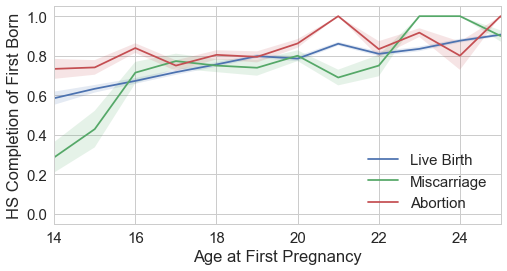

In [6]:
df = pd.read_sql(con = con, 
                 sql = """select 
                            static.age1p,
                            static.age1b age1b, out1p,
                            hsdiploma HS, 
                            hstdegree_dli > 3 BA, 
                            cyrb
                          from static
                          join cya_static on 
                            static.r = cya_static.r and
                            bthordr = 1
                          where 
                            age1p > 11 and
                            hstdegree_dli >= 0 and
                            2012 - cyrb > 20 and
                            out1p >= 0
                          ;
                       """)

fig, ax = plt.subplots(figsize=(8, 4))
for vi, v, c in [[1, "Live Birth", "b"], 
                 [2, "Miscarriage", "g"], 
                 [4, "Abortion", "r"]]:

    dfg = df[df["out1p"] == vi].groupby("age1p")
    dfp = dfg.mean()

    dfp["err"] = dfp["HS"] * (1 - dfp["HS"])/np.sqrt(dfg.count()["HS"])
    
    plt.plot(dfp.index, dfp["HS"], label = v)
    plt.fill_between(dfp.index, dfp["HS"] - dfp["err"], dfp["HS"] + dfp["err"],
                     alpha = 0.15, facecolor = c)

ax.set(xlabel = "Age at First Pregnancy", 
       ylabel = "HS Completion of First Born",
       xbound = (14, 25))
plt.legend(loc = "best")

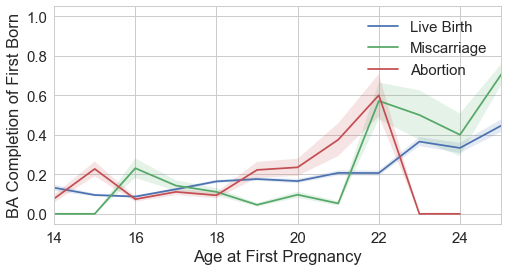

In [7]:
df = pd.read_sql(con = con, 
                 sql = """select 
                            static.age1p,
                            static.age1b age1b, out1p,
                            hstdegree_dli > 3 BA, 
                            cyrb
                          from static
                          join cya_static on 
                            static.r = cya_static.r and
                            bthordr = 1
                          where 
                            age1p > 11 and
                            hstdegree_dli >= 0 and
                            2012 - cyrb > 25 and
                            out1p >= 0
                          ;
                       """)

fig, ax = plt.subplots(figsize=(8, 4))
for vi, v, c in [[1, "Live Birth", "b"], 
                 [2, "Miscarriage", "g"], 
                 [4, "Abortion", "r"]]:

    dfg = df[df["out1p"] == vi].groupby("age1p")
    dfp = dfg.mean()

    plt.plot(dfp.index, dfp["BA"], label = v)

    dfp["err"] = dfp["BA"] * (1 - dfp["BA"])/np.sqrt(dfg.count()["BA"])
    plt.fill_between(dfp.index, dfp["BA"] - dfp["err"], dfp["BA"] + dfp["err"],
                     alpha = 0.15, facecolor = c)

ax.set(xlabel = "Age at First Pregnancy", 
       ylabel = "BA Completion of First Born",
       xbound = (14, 25))
plt.legend(loc = "best")

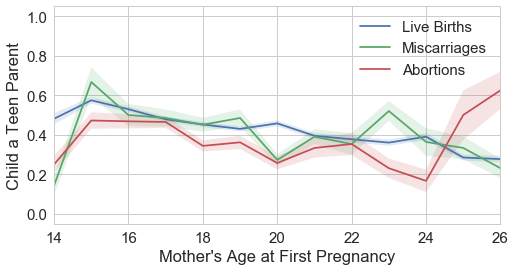

In [8]:
df = pd.read_sql(con = con, 
                 sql = """select 
                            static.age1p, out1p,
                            ABS(cya_static.age1b) < 20 teen
                          from static
                          join cya_static on 
                            static.r = cya_static.r and bthordr = 1
                          where 2012 - cyrb > 20 and out1p >= 0;""")

fig, ax = plt.subplots(figsize=(8, 4))
for vi, v, c in [[1, "Live Births", "b"], [2, "Miscarriages", "g"], [4, "Abortions", "r"]]:

    dfg = df[df["out1p"] == vi].groupby("age1p")
    dfp = dfg.mean()
    
    dfp["err"] = dfp["teen"] * (1 - dfp["teen"])/np.sqrt(dfg.count()["teen"])
    
    plt.plot(dfp.index, dfp["teen"], label = v)
    plt.fill_between(dfp.index, dfp["teen"] - dfp["err"], dfp["teen"] + dfp["err"],
                     alpha = 0.15, facecolor = c)

ax.set(xlabel = "Mother's Age at First Pregnancy", ylabel = "Child a Teen Parent", xbound = (14, 26))
plt.legend(loc = "best")

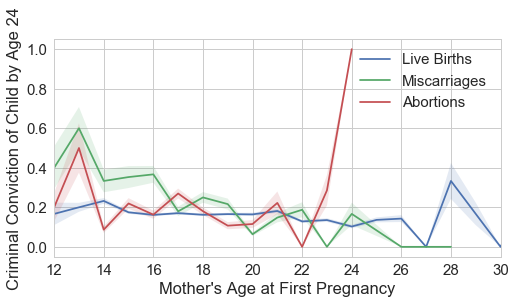

In [9]:
df = pd.read_sql(con = con, index_col = ["r"],
                 sql = """select
                            cya_self.r,
                            static.age1p, out1p,
                            sum(yasr_62a > 0 and ageint <= 24) > 0 crimrec,
                            max(ageint) maxage
                          from cya_self
                          join static on static.r = cya_self.r
                          join cya_static on 
                            static.r = cya_static.r and
                            bthordr = 1
                          join cya_yearly on
                            cya_self.r = cya_yearly.r and
                            cya_self.c = cya_yearly.c and
                            cya_self.y = cya_yearly.y
                          where
                            age1p >= 0 and
                            yasr_62a is not null 
                          group by
                            cya_self.r, cya_self.c
                          having
                            max(ageint) > 24
                          ;
                       """)

fig, ax = plt.subplots(figsize=(8, 4))
for vi, v, c in [[1, "Live Births", "b"], 
                 [2, "Miscarriages", "g"], 
                 [4, "Abortions", "r"]]:

    dfg = df[df["out1p"] == vi].groupby("age1p")
    dfp = dfg.mean()

    dfp["err"] = dfp["crimrec"] * (1 - dfp["crimrec"]) / \
                 np.sqrt(dfg.count()["crimrec"])
    
    plt.plot(dfp.index, dfp["crimrec"], label = v)
    plt.fill_between(dfp.index, 
                     dfp["crimrec"] - dfp["err"], 
                     dfp["crimrec"] + dfp["err"],
                     alpha = 0.15, facecolor = c)

ax.set(xlabel = "Mother's Age at First Pregnancy", 
       ylabel = "Criminal Conviction of Child by Age 24",
       xbound = (12, 30))
plt.legend(loc = "best")

In [10]:
df = pd.read_sql(con = con,
                 sql = """select 
                            cya_static.r, cya_static.c, static.age1p, static.out1p,
                            magebir,
                            CASE WHEN(homep>0) THEN homep ELSE NULL END homep, 
                            CASE WHEN(mathp>0) THEN mathp ELSE NULL END mathp, 
                            CASE WHEN(compp>0) THEN compp ELSE NULL END compp 
                          from cya_psych 
                          join static on static.r = cya_psych.r
                          join cya_static on 
                            cya_static.r = cya_psych.r and 
                            cya_static.c = cya_psych.c
                          where bthordr = 1
                       """)

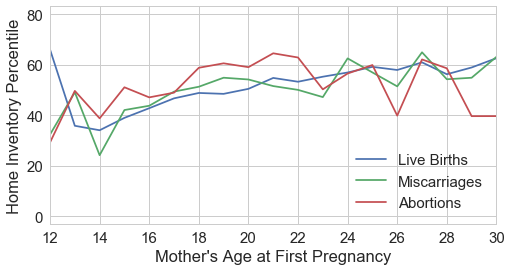

In [11]:
fig, ax = plt.subplots(figsize=(8, 4))
for vi, v, c in [[1, "Live Births", "b"], [2, "Miscarriages", "g"], [4, "Abortions", "r"]]:

    dfp = df[df["out1p"] == vi].groupby("age1p").mean()
    plt.plot(dfp.index, dfp["homep"], label = v)

ax.set(xlabel = "Mother's Age at First Pregnancy", 
       ylabel = "Home Inventory Percentile", xbound = (12, 30))
plt.legend(loc = "best")

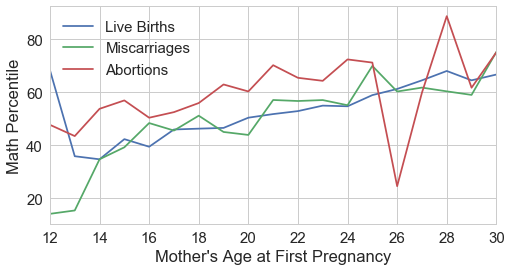

In [12]:
fig, ax = plt.subplots(figsize=(8, 4))
for vi, v, c in [[1, "Live Births", "b"], [2, "Miscarriages", "g"], [4, "Abortions", "r"]]:

    dfp = df[df["out1p"] == vi].groupby("age1p").mean()
    plt.plot(dfp.index, dfp["mathp"], label = v)

ax.set(xlabel = "Mother's Age at First Pregnancy", ylabel = "Math Percentile", xbound = (12, 30))
plt.legend(loc = "best")

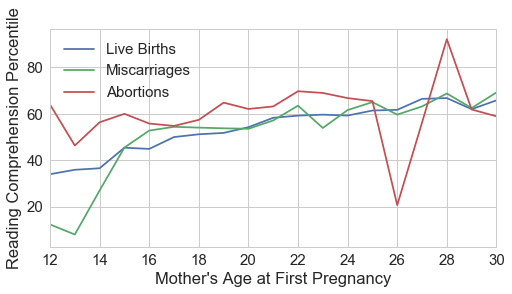

In [13]:
fig, ax = plt.subplots(figsize=(8, 4))
for vi, v, c in [[1, "Live Births", "b"], [2, "Miscarriages", "g"], [4, "Abortions", "r"]]:

    dfp = df[df["out1p"] == vi].groupby("age1p").mean()
    plt.plot(dfp.index, dfp["compp"], label = v)

ax.set(xlabel = "Mother's Age at First Pregnancy", ylabel = "Reading Comprehension Percentile", xbound = (12, 30))
plt.legend(loc = "best")

[<matplotlib.text.Text at 0x7f7427a6ce80>, None]

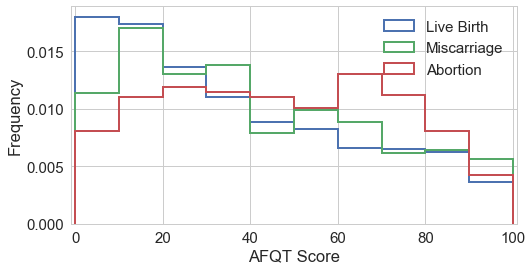

In [14]:
df = pd.read_sql(con = con, 
                 sql = """select out1p, afqt_2, static.age1b age1b
                          from static
                          join cya_static on 
                            static.r = cya_static.r and bthordr = 1
                          where age1p > 11 and out1p >= 0;""")

labels = {1 : "Live Birth", 2 : "Miscarriage", 4 : "Abortion"}
fig, ax = plt.subplots(figsize=(8, 4))
for l, g in df.groupby("out1p"):
    g.plot(kind = "hist", y = "afqt_2", label = labels[l], bins = range(0, 101, 10), 
           histtype = "step", ax = ax, normed = True, linewidth = 2)
ax.set(xlabel = "AFQT Score", xbound = (-1, 101))